In [1]:
import torchvision
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


train_data = torchvision.datasets.MNIST("./", train=True,\
transform=transforms.Compose([transforms.Grayscale(num_output_channels=3),\
transforms.Resize(256),transforms.ToTensor()]), download=True)
test_data = torchvision.datasets.MNIST("./", train=False,\
transform=transforms.Compose([transforms.Grayscale(num_output_channels=3),\
transforms.Resize(256),transforms.ToTensor()]), download=True)


batch_size = 64
# Create data loaders.
train_dataloader = DataLoader(train_data, shuffle = True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in (test_dataloader):
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64


In [2]:
# use cpu or gpu device if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
loss_fn = nn.CrossEntropyLoss()

AlexModel = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
AlexModel.classifier[6] = nn.Linear(4096, 10)
AlexModel.to(device)
optimizerAlex = torch.optim.SGD(AlexModel.classifier.parameters(), lr=1e-3) 


class LRModel(nn.Module):
    def __init__(self):
        super(LRModel, self).__init__()
        self.flatten = nn.Flatten()
        self.LR = nn.Linear(256*256*3, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        linearReg = self.LR(x)
        return linearReg
    
LRModel = LRModel().to(device)
optimizerLR = torch.optim.SGD(LRModel.parameters(), lr=1e-3) 

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Using cpu device


Using cache found in C:\Users\jnloz/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\jnloz\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jnloz\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#AlexModel
#This code taken from old lecture video to make training faster 
for param in AlexModel.features.parameters():
    param.requires_grad = False
        
torch.manual_seed(0)
epochs = 20
for t in range(epochs):
    start = time.time()
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, AlexModel, loss_fn, optimizerAlex)
    test(test_dataloader, AlexModel, loss_fn)
    #torch.save(AlexModel.state_dict(), f"AlexNet.pt")
    print(f'Epoch ran in {time.time() - start :.2f} seconds')
print("Done!")
torch.save(AlexModel.state_dict(), "AlexNet.pt")

In [ ]:
#Linear Regression model
torch.manual_seed(0)
epochs = 20
for t in range(epochs):
    start = time.time()
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, LRModel, loss_fn, optimizerLR)
    test(test_dataloader, LRModel, loss_fn)
    print(f'Epoch ran in {time.time() - start :.2f} seconds')
print("Done!")
torch.save(LRModel.state_dict(), "LRModel.pt")

In [3]:
#models trained on hamming saved to local directory 
#torch.save(AlexModel.state_dict(), "AlexNet.pt")
AlexModel.load_state_dict(torch.load("AlexNet.pt",map_location=torch.device('cpu'), weights_only=True))
AlexModel.eval()
LRModel.load_state_dict(torch.load("LRModel.pt",map_location=torch.device('cpu'), weights_only=True))
LRModel.eval()

LRModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (LR): Linear(in_features=196608, out_features=10, bias=True)
)

True label is [4]
Image Classified as [4] with probability 0.9995526671409607


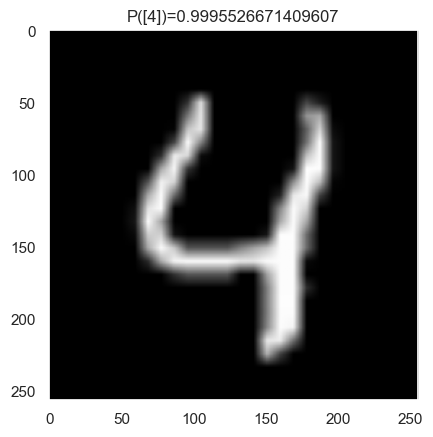

Image Classified as [4] with probability 0.9809276461601257


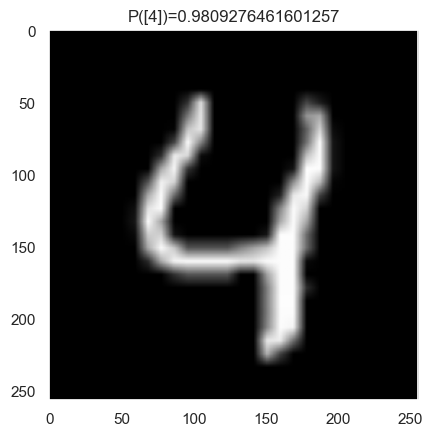

In [4]:

img_to_perturb, label_to_perturb = test_dataloader.dataset[4] #Image is a 4. Using this since probablity from homework 6 was low

print(f"True label is {[label_to_perturb]}")

def plot_img_w_prob(model, img, label, save=None):
    with torch.no_grad():
        prob_dist = torch.softmax(model(img.unsqueeze(0).to(device)), 1)
        img_class = prob_dist.argmax(1)
        print(f"Image Classified as {[img_class.item()]} with probability {prob_dist[0, img_class].item()}")
        plt.title(f"P({[label]})={torch.softmax(model(img.unsqueeze(0).to(device)), 1)[0, label]}")
        plt.imshow(img.permute(1, 2, 0))
        plt.grid(False)
        if save is not None:
            plt.savefig(save, bbox_inches='tight', pad_inches=0)
        plt.show()
        
plot_img_w_prob(AlexModel, img_to_perturb, label_to_perturb)
plot_img_w_prob(LRModel, img_to_perturb, label_to_perturb)

In [5]:
def adv_perturb_untargeted(X, true_label, model, loss_fn, itrs=10, step=.01):
    X_pert = X.clone()
    X_pert.requires_grad = True
    for itr in range(itrs):
        pred = model(X_pert.unsqueeze(0).to(device))
        loss = loss_fn(pred, torch.tensor([true_label]).to(device))
        loss.backward()
        X_pert.data += step*X_pert.grad
        X_pert.grad.zero_()
    return X_pert.detach()

AlexNet


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Classified as [0] with probability 0.9999955892562866


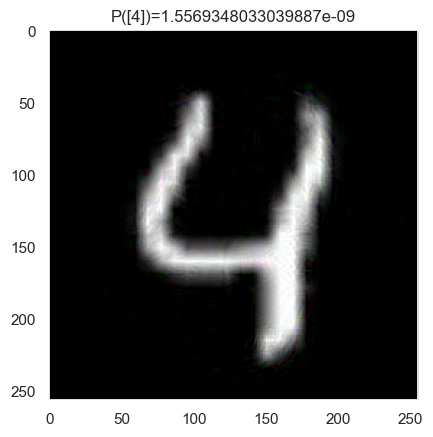


Linear


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Classified as [4] with probability 0.9379197359085083


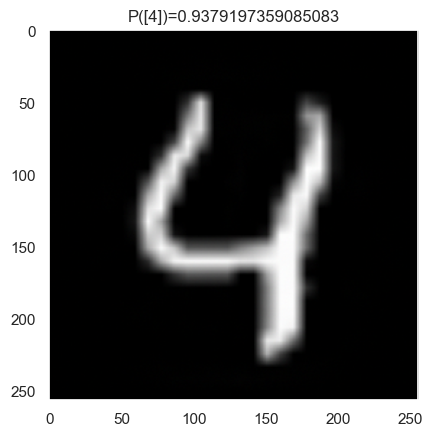


The AlexNet model is more vulnerable to adverserial perturbation, which makes sense since in lecture it was discussed that more complex models lead to these issues. It detects the image as 0 with .999 probability even though the image still looks like a 4.


In [16]:
print("AlexNet")
pert_img = adv_perturb_untargeted(img_to_perturb, label_to_perturb, AlexModel, loss_fn, itrs=250, step=.23)
#plot_img_w_prob(AlexModel, img_to_perturb, 4)
plot_img_w_prob(AlexModel, pert_img, 4)
#img_diff = pert_img - img_to_perturb
#plot_img_w_prob(AlexModel, (img_diff - img_diff.min())/(img_diff.max() - img_diff.min()), 4)

print("\nLinear")
pert_img = adv_perturb_untargeted(img_to_perturb, label_to_perturb, LRModel, loss_fn, itrs=250, step=.23)
#plot_img_w_prob(LRModel, img_to_perturb, 4)
plot_img_w_prob(LRModel, pert_img, 4)
#img_diff = pert_img - img_to_perturb
#plot_img_w_prob(LRModel, (img_diff - img_diff.min())/(img_diff.max() - img_diff.min()), 4)
print("\nThe AlexNet model is more vulnerable to adverserial perturbation, which makes sense since in lecture it was discussed that more complex models lead to these issues. It detects the image as 0 with .999 probability even though the image still looks like a 4.")

In [18]:
def adv_perturb_targeted(X, target_label, model, loss_fn, itrs=10, step=.01):
    X_pert = X.clone()
    X_pert.requires_grad = True
    for itr in range(itrs):
        pred = model(X_pert.unsqueeze(0).to(device))
        loss = loss_fn(pred, torch.tensor([target_label]).to(device))
        loss.backward()
        X_pert.data -= step*X_pert.grad
        X_pert.grad.zero_()
    return X_pert.detach()

AlexNet


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Classified as [7] with probability 0.8606560826301575


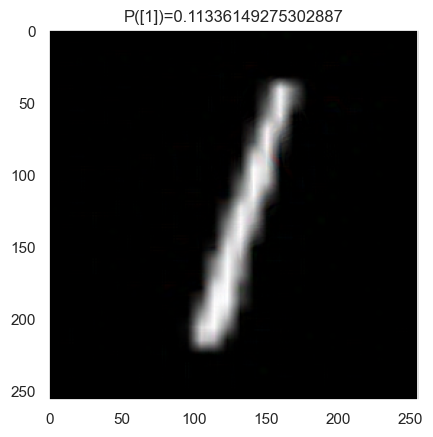


Linear


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Classified as [1] with probability 0.9678431153297424


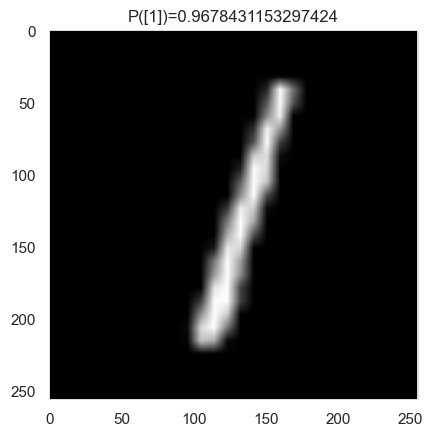

Once again the AlexNet is much more vulnerable. With the same iterations/steps, the logistic model is still classifying the image as 1 with high probability, while the AlexNet is wrongly classifying it as 7 with high probability.


In [21]:
img_to_perturb, label_to_perturb = test_dataloader.dataset[2] #Image is a 1

print("AlexNet")
pert_img = adv_perturb_targeted(img_to_perturb, 7, AlexModel, loss_fn, itrs=100, step=.01)
plot_img_w_prob(AlexModel, pert_img, 1)
#img_diff = pert_img - img_to_perturb
#plot_img_w_prob(AlexModel, (img_diff - img_diff.min())/(img_diff.max() - img_diff.min()), 7)

print("\nLinear")
pert_img = adv_perturb_targeted(img_to_perturb, 7, LRModel, loss_fn, itrs=100, step=.01)
plot_img_w_prob(LRModel, pert_img, 1)
#img_diff = pert_img - img_to_perturb
#plot_img_w_prob(LRModel, (img_diff - img_diff.min())/(img_diff.max() - img_diff.min()), 7)

print("Once again the AlexNet is much more vulnerable. With the same iterations/steps, the logistic model is still classifying the image as 1 with high probability, while the AlexNet is wrongly classifying it as 7 with high probability.")